In [7]:
import sys
## add sys path
path_to_add = '/Users/yaqifan/Documents/Github/LOCAETA/src'
if path_to_add not in sys.path:
    sys.path.insert(0, path_to_add)

import cdsapi
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import xarray as xr
from utils.path_util import DATA_PATH

In [ ]:
## For data download

# dataset = "reanalysis-era5-land-monthly-means"
# request = {
#     "product_type": ["monthly_averaged_reanalysis"],
#     "variable": [
#         "2m_dewpoint_temperature",
#         "2m_temperature",
#         "10m_u_component_of_wind",
#         "10m_v_component_of_wind",
#         "surface_pressure",
#         "total_precipitation",
#         "high_vegetation_cover",
#         "lake_cover",
#         "low_vegetation_cover"
#     ],
#     "year": ["2023"],
#     "month": [
#         "01", "02", "03",
#         "04", "05", "06",
#         "07", "08", "09",
#         "10", "11", "12"
#     ],
#     "time": ["00:00"],
#     "data_format": "netcdf",
#     "download_format": "zip",
#     "area": [40.32, -105.5, 39.41, -104.41]
# }

# client = cdsapi.Client()
# client.retrieve(dataset, request).download()


Loading with xarray...
=== Xarray Dataset ===
xarray.Dataset {
dimensions:
	valid_time = 12 ;
	latitude = 10 ;
	longitude = 11 ;

variables:
	float32 d2m(valid_time, latitude, longitude) ;
		d2m:GRIB_paramId = 168 ;
		d2m:GRIB_dataType = fc ;
		d2m:GRIB_numberOfPoints = 110 ;
		d2m:GRIB_typeOfLevel = surface ;
		d2m:GRIB_stepUnits = 1 ;
		d2m:GRIB_gridType = regular_ll ;
		d2m:GRIB_uvRelativeToGrid = 0 ;
		d2m:GRIB_NV = 0 ;
		d2m:GRIB_Nx = 11 ;
		d2m:GRIB_Ny = 10 ;
		d2m:GRIB_cfName = unknown ;
		d2m:GRIB_cfVarName = d2m ;
		d2m:GRIB_gridDefinitionDescription = Latitude/Longitude Grid ;
		d2m:GRIB_iDirectionIncrementInDegrees = 0.1 ;
		d2m:GRIB_iScansNegatively = 0 ;
		d2m:GRIB_jDirectionIncrementInDegrees = 0.1 ;
		d2m:GRIB_jPointsAreConsecutive = 0 ;
		d2m:GRIB_jScansPositively = 0 ;
		d2m:GRIB_latitudeOfFirstGridPointInDegrees = 40.31 ;
		d2m:GRIB_latitudeOfLastGridPointInDegrees = 39.41 ;
		d2m:GRIB_longitudeOfFirstGridPointInDegrees = -105.5 ;
		d2m:GRIB_longitudeOfLastGridPointI

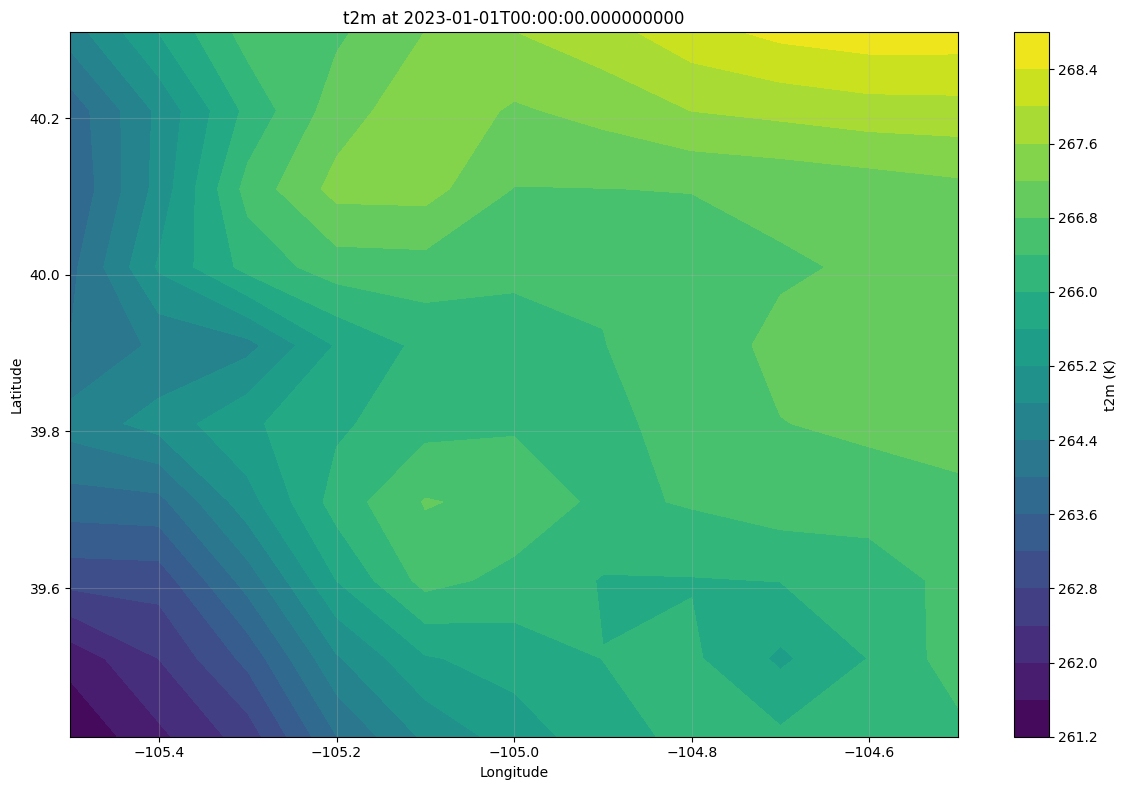


=== Analysis Examples ===
Temperature range: -11.9°C to 23.6°C
Mean temperature: 7.1°C
Total precipitation range: 0.008 to 0.014 m
Maximum wind speed: 2.6 m/s


In [10]:
# Variable descriptions for your data:
variable_descriptions = {
    'd2m': '2-meter dewpoint temperature (K)',
    't2m': '2-meter temperature (K)', 
    'u10': '10-meter u-component of wind (m/s)',
    'v10': '10-meter v-component of wind (m/s)',
    'sp': 'Surface pressure (Pa)',
    'tp': 'Total precipitation (m)'
    }

def load_with_xarray(filename):
    """Load netCDF file using xarray (more convenient for analysis)"""
    ds = xr.open_dataset(filename)
    
    print("=== Xarray Dataset ===")
    print(ds.info())
    
    # Convert temperature from Kelvin to Celsius if needed
    if 't2m' in ds.variables:
        if ds.t2m.max() > 100:  # Likely in Kelvin
            ds['t2m_celsius'] = ds.t2m - 273.15
    
    if 'd2m' in ds.variables:
        if ds.d2m.max() > 100:  # Likely in Kelvin  
            ds['d2m_celsius'] = ds.d2m - 273.15
    
    # Calculate wind speed
    if 'u10' in ds.variables and 'v10' in ds.variables:
        ds['wind_speed'] = np.sqrt(ds.u10**2 + ds.v10**2)
    
    return ds

def plot_weather_data(dataset, variable='t2m', time_idx=0):
    """Create a simple map plot of weather data"""
    plt.figure(figsize=(12, 8))
    
    # Get data for specific time
    data = dataset[variable].isel(valid_time=time_idx)
    
    # Create contour plot
    plt.contourf(dataset.longitude, dataset.latitude, data, levels=20, cmap='viridis')
    plt.colorbar(label=f'{variable} ({data.units if hasattr(data, "units") else ""})')
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{variable} at {dataset.valid_time[time_idx].values}')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example usage

filename = f"{DATA_PATH}/ERA5_monthly_raw/data_stream-moda.nc"  # Replace with your actual filename

print("\nLoading with xarray...")
ds = load_with_xarray(filename)

# Create a plot
plot_weather_data(ds, 't2m', 0)

# Additional analysis examples
print("\n=== Analysis Examples ===")

# Temperature statistics
if 't2m' in ds.variables:
    temp_celsius = ds.t2m - 273.15
    print(f"Temperature range: {temp_celsius.min().values:.1f}°C to {temp_celsius.max().values:.1f}°C")
    print(f"Mean temperature: {temp_celsius.mean().values:.1f}°C")

# Precipitation analysis
if 'tp' in ds.variables:
    total_precip = ds.tp.sum(dim='valid_time')
    print(f"Total precipitation range: {total_precip.min().values:.3f} to {total_precip.max().values:.3f} m")

# Wind analysis
if 'wind_speed' in ds.variables:
    max_wind = ds.wind_speed.max()
    print(f"Maximum wind speed: {max_wind.values:.1f} m/s")

